In [1]:
using Distributions, LinearAlgebra, Plots, Random, LargeMessageCollider
Random.seed!(12345);

┌ Info: Precompiling LargeMessageCollider [7f03d5f0-357e-4842-abc9-7001c0bc8a0e]
└ @ Base loading.jl:1278


This example is due to Bayesian Filtering and Smoothing by Simo Sarkka (Example 5.1 Pendulum Tracking)

In [2]:
# Generate synthetic data

Δt = 0.01 # time gap
g = 10 # gravitational constant
q_c = 1 # spectral density of process noise
f(x::Array) = [x[1] + x[2]*Δt, x[2] - g*sin(x[1])*Δt] # nonlinear transition function
h(x::Array) = sin(x[1]) # nonlinear emission function
Q = [q_c*Δt^3/3 q_c*Δt^2/2; q_c*Δt^2/2 q_c*Δt] # transition noise covariance
R = 0.2 # emission noise variance
T = 500

# Generate data
α_real = [pi/2] # angle for visualization purpose
x_real = [[α_real[1],0]]
y = [h(x_real[1]) + sqrt(R)*randn()]
for t=2:T
    x_new = f(x_real[t-1]) # swinging in perfect conditions (no noise in process)
    push!(x_real, x_new)
    push!(α_real,x_new[1])
    y_new = h(x_real[t]) + sqrt(R)*randn() # imperfect measurements (noisy)
    push!(y, y_new)
end

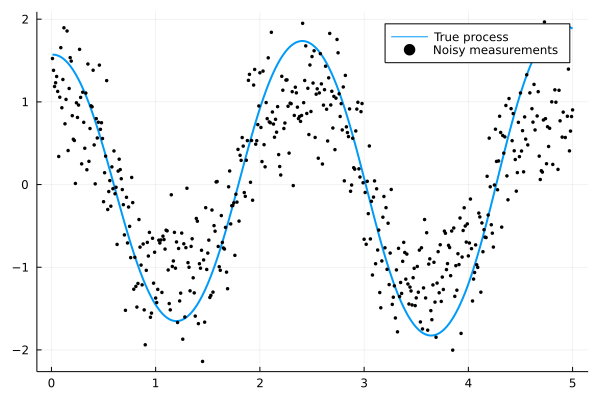

In [3]:
plot(Δt * collect(1:500), α_real, lw=2, label="True process")
scatter!(Δt * collect(1:500), y, color=:black, markersize=2, label="Noisy measurements")

In [4]:
# Extended Kalman Filtering

p1 = MvNormal(zeros(2),1) #prior

taylor = TSL()

posterior_filter = [approximateMarginal!(taylor, h, y[1]+Normal(0,sqrt(R)),p1)]

# Recursive estimation
m_forw = p1 # just to make m_forw global and use in backward message calculation for smoothing at the last time step
for t=2:T
    m_forw_ = forwardMessage(taylor, f, posterior_filter[t-1]) + MvNormal(zeros(2),Q)
    m_forw = m_forw_ + MvNormal(zeros(2),Q)
    push!(posterior_filter, approximateMarginal!(taylor, h, y[t]+Normal(0,sqrt(R)),m_forw))
end

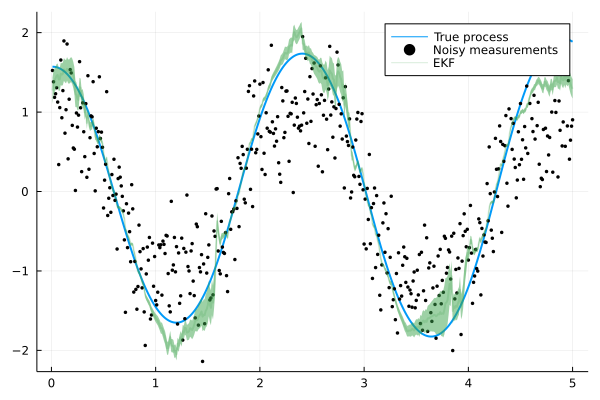

In [5]:
# Filtering Estimations
posterior_filter_α_mean = zeros(T)
posterior_filter_α_var = zeros(T)
for t=1:T
    posterior_filter_α_mean[t] = mean(posterior_filter[t])[1]
    posterior_filter_α_var[t] = cov(posterior_filter[t])[1,1]
end

plot(Δt * collect(1:500), α_real, lw=2, label="True process")
scatter!(Δt * collect(1:500), y, color=:black, markersize=2, label="Noisy measurements")
plot!(Δt * collect(1:500), posterior_filter_α_mean, ribbon=posterior_filter_α_var, alpha=0.2, lw=2, label="EKF")

In [6]:
# Extended Kalman Smoothing
posterior_smooth = Array{MvNormal}(undef, T)
posterior_smooth[T] = posterior_filter[T]

m_back_ = posterior_filter[T]/m_forw
m_back = convert(Distribution, m_back_ - MvNormal(zeros(2),Q))
for t=T-1:-1:1
    m_back_ = ep!(taylor, f, m_back, posterior_filter[t])
    posterior_smooth[t] = posterior_filter[t]*m_back_
    m_back = convert(Distribution, m_back_ - MvNormal(zeros(2),Q))
end

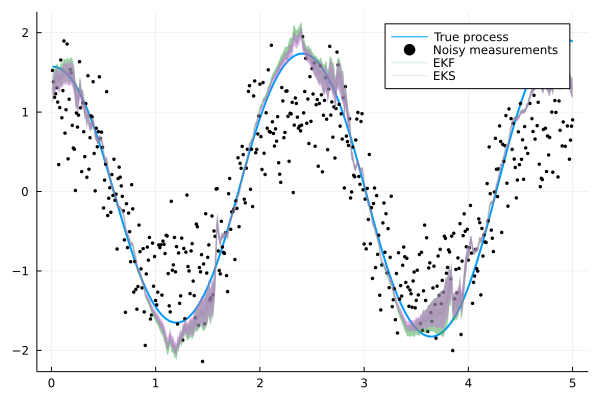

In [7]:
# Smoothing Estimations
posterior_smooth_α_mean = zeros(T)
posterior_smooth_α_var = zeros(T)
for t=1:T
    posterior_smooth_α_mean[t] = mean(posterior_smooth[t])[1]
    posterior_smooth_α_var[t] = cov(posterior_smooth[t])[1,1]
end

plot(Δt * collect(1:500), α_real, lw=2, label="True process")
scatter!(Δt * collect(1:500), y, color=:black, markersize=2, label="Noisy measurements")
plot!(Δt * collect(1:500), posterior_filter_α_mean, ribbon=posterior_filter_α_var, alpha=0.2, lw=2, label="EKF")
plot!(Δt * collect(1:500), posterior_smooth_α_mean, ribbon=posterior_smooth_α_var, alpha=0.2, lw=2, label="EKS")